<a href="https://colab.research.google.com/github/Boingabu/programacion_avanzada/blob/main/Taller_de_m%C3%A9todos_de_regresi%C3%B3n_y_predicci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Series_reference', 'Period', 'Data_value', 'Suppressed', 'STATUS',
       'UNITS', 'Magnitude', 'Subject', 'Group', 'Series_title_1',
       'Series_title_2', 'Series_title_3', 'Series_title_4', 'Series_title_5'],
      dtype='object')
Datos faltantes: 749


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mejores parámetros encontrados: ARIMA(3, 0, 3)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

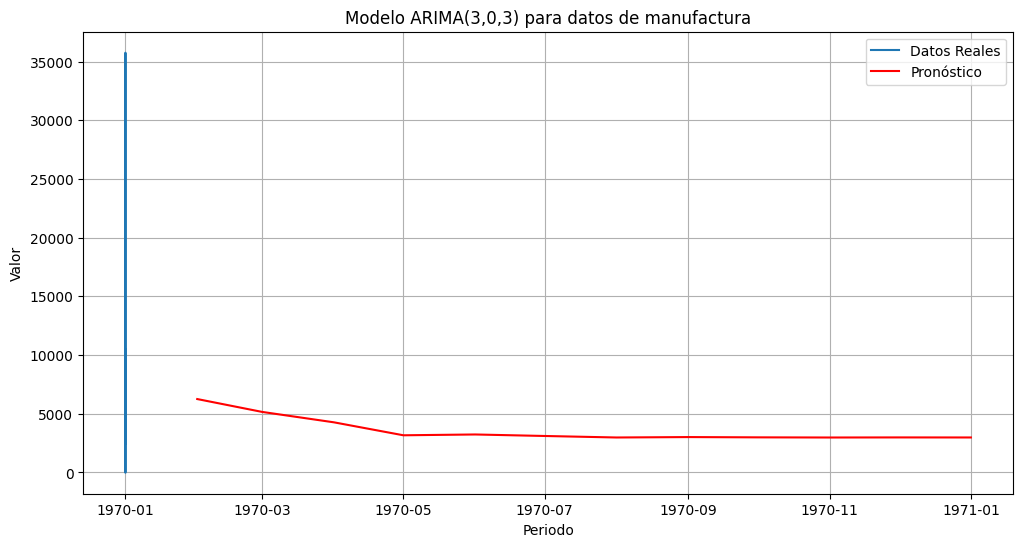

                               SARIMAX Results                                
Dep. Variable:             Data_value   No. Observations:                29074
Model:                 ARIMA(3, 0, 3)   Log Likelihood             -286493.865
Date:                Sat, 26 Apr 2025   AIC                         573003.730
Time:                        01:33:13   BIC                         573069.951
Sample:                             0   HQIC                        573025.010
                              - 29074                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2975.8307     60.256     49.387      0.000    2857.732    3093.929
ar.L1         -0.1938      0.061     -3.196      0.001      -0.313      -0.075
ar.L2         -0.0071      0.055     -0.130      0.8

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from itertools import product

df = pd.read_csv('/content/economic-survey-of-manufacturing-december-2024.zip')

print(df.columns)

df = df[['Period', 'Data_value']].copy()
df['Period'] = pd.to_datetime(df['Period'])
df = df.set_index('Period').sort_index()

# Verificar datos faltantes
print(f"Datos faltantes: {df['Data_value'].isnull().sum()}")

# Eliminar datos faltantes si los hay
df = df.dropna()

# Función para test de estacionariedad
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]  # p-value

# Determinar el orden de diferenciación (d)
def find_d(series):
    d = 0
    p_value = test_stationarity(series)
    while p_value > 0.05 and d < 2:  # Limitamos a 2 diferenciaciones para evitar sobre-diferenciación
        d += 1
        p_value = test_stationarity(series.diff(d).dropna())
    return d

# Función para encontrar mejores p y q usando AIC
def find_best_pq(series, d, max_p=3, max_q=3):
    best_aic = np.inf
    best_order = (0, d, 0)

    # Generar todas las combinaciones posibles de p y q
    for p, q in product(range(max_p+1), range(max_q+1)):
        try:
            model = ARIMA(series, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue

    return best_order

# Encontrar parámetros óptimos
d = find_d(df['Data_value'])
best_p, best_d, best_q = find_best_pq(df['Data_value'], d)

print(f"Mejores parámetros encontrados: ARIMA({best_p}, {best_d}, {best_q})")

# Ajustar el modelo con los mejores parámetros
modelo = ARIMA(df['Data_value'], order=(best_p, best_d, best_q))
modelo_ajustado = modelo.fit()


pronostico = modelo_ajustado.forecast(steps=12)

ultima_fecha = df.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha, periods=len(pronostico)+1, freq='MS')[1:]  # Asume frecuencia mensual

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Data_value'], label='Datos Reales')
plt.plot(fechas_futuras, pronostico, label='Pronóstico', color='red')
plt.title(f'Modelo ARIMA({best_p},{best_d},{best_q}) para datos de manufactura')
plt.xlabel('Periodo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar resumen del modelo
print(modelo_ajustado.summary())